In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import numpy as np
import argparse
import soundfile as sf
from scipy.io.wavfile import write
import librosa
from scipy.special import expi
import librosa.display
import matplotlib.pyplot as plt
import pickle
from skimage.metrics import structural_similarity as ssim
torch.backends.cudnn.deterministic = True
seed=1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [2]:
class Unet(nn.Module):
    def __init__(self,nlayers=12,nefilters=12):
        super(Unet, self).__init__()
        self.num_layers=nlayers
        self.nefilters=nefilters
        filter_size=15
        merge_filter_size=5
        self.encoder=nn.ModuleList()
        self.decoder=nn.ModuleList()
        self.ebatch=nn.ModuleList()
        self.dbatch=nn.ModuleList()
        echannelin=[1]+[(i+1)*nefilters for i in range(nlayers-1)]
        echannelout=[(i+1)*nefilters for i in range(nlayers)]
        dchannelout=echannelout[::-1]
        dchannelin=[dchannelout[0]*2]+[(i)*nefilters+(i-1)* nefilters for i in range(nlayers,1,-1)]
        for i in range(self.num_layers):
            self.encoder.append(nn.Conv1d(echannelin[i],echannelout[i],filter_size,padding=filter_size//2))
            self.decoder.append(nn.Conv1d(dchannelin[i],dchannelout[i],merge_filter_size,padding=merge_filter_size//2))
            self.ebatch.append(nn.BatchNorm1d(echannelout[i]))
            self.dbatch.append(nn.BatchNorm1d(dchannelout[i]))
        rates=[1,2,3,4]
        self.aspp1=ASPP(echannelout[-1],echannelout[-1]//4,rate=rates[0])
        self.aspp2=ASPP(echannelout[-1],echannelout[-1]//4,rate=rates[1])
        self.aspp3=ASPP(echannelout[-1],echannelout[-1]//4,rate=rates[2])
        self.aspp4=ASPP(echannelout[-1],echannelout[-1]//4,rate=rates[3])
        self.global_avg_pool=nn.Sequential(nn.AdaptiveAvgPool1d(1),nn.Conv1d(echannelout[-1],echannelout[-1]//4,1,bias=False),nn.LeakyReLU(0.1))
        self.middle=nn.Sequential(nn.Conv1d(echannelout[-1]//4*5,echannelout[-1],1,bias=False),nn.BatchNorm1d(echannelout[-1]),nn.LeakyReLU(0.1))
        self.out=nn.Sequential(nn.Conv1d(nefilters + 1, 1, 1),nn.Tanh())
    def forward(self,x):
        encoder=list()
        input=x
        for i in range(self.num_layers):
            x=self.encoder[i](x)
            x=self.ebatch[i](x)
            x=F.leaky_relu(x,0.1)
            encoder.append(x)
            x=x[:,:,::2]
        x1=self.aspp1(x)
        x2=self.aspp2(x)
        x3=self.aspp3(x)
        x4=self.aspp4(x)
        x5=self.global_avg_pool(x)
        x5=F.interpolate(x5,size=x4.size()[2:],mode='linear',align_corners=True)
        x=torch.cat((x1, x2, x3, x4, x5), dim=1)
        x=self.middle(x)
        for i in range(self.num_layers):
            x=F.interpolate(x,scale_factor=2,mode='linear', align_corners=False)
            x=torch.cat([x,encoder[self.num_layers-i-1]],dim=1)
            x=self.decoder[i](x)
            x=self.dbatch[i](x)
            x=F.leaky_relu(x,0.1)
        x=torch.cat([x,input],dim=1)
        x=self.out(x)
        return x
    
class ASPP(nn.Module):
    def __init__(self, inplanes, planes, rate):
        super(ASPP, self).__init__()
        if rate==1:
            kernel_size=1
            padding=0
        else:
            kernel_size=3
            padding=rate
        self.convbnre=nn.Sequential(nn.Conv1d(inplanes,planes,kernel_size=kernel_size,stride=1,padding=padding,dilation=rate,bias=False),nn.BatchNorm1d(planes),nn.LeakyReLU(0.1))
        self.__init_weight()

    def forward(self, x):
        return self.convbnre(x)

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [3]:
class Accumulator:
    def __init__(self,noisy_audio,clean_audio,low_cut,high_cut,nfft,hop_length,residual,sr,bandpass):
        self.low_cut=low_cut
        self.high_cut=high_cut
        self.hop_length=hop_length
        self.nfft=nfft
        self.stft_noisy=torch_stft(noisy_audio,nfft=nfft,hop_length=hop_length)
        self.stft_clean=torch_stft(clean_audio,nfft=nfft,hop_length=hop_length)
        self.residual=residual
        self.sr=sr
        self.bandpass=bandpass
        self.stft_diff_sum=np.zeros(self.stft_noisy.shape)

    def sum_difference(self,stft,iter_num):
        if iter_num<50:
            self.stft_prev,self.stft_minus=stft,stft
        else:
            self.stft_minus=np.abs(stft-self.stft_prev)/(stft+np.finfo(float).eps)
            self.stft_diff_sum+=self.stft_minus
            self.stft_diff_sum[self.stft_diff_sum<np.percentile(self.stft_diff_sum,self.low_cut)]=np.percentile(self.stft_diff_sum,self.low_cut)
            self.stft_diff_sum[self.stft_diff_sum>np.percentile(self.stft_diff_sum,self.high_cut)]=np.percentile(self.stft_diff_sum,self.high_cut)
            self.stft_prev=stft

    def create_atten_map(self):
        max_mask=self.stft_diff_sum.max()
        min_mask=self.stft_diff_sum.min()
        atten_map=(max_mask-self.stft_diff_sum)/(max_mask-min_mask)
        atten_map[atten_map<self.residual]=self.residual
        self.atten_map=atten_map

    def mmse_lsa(self):
        gamma_mat=(1 - self.atten_map) ** 2
        gamma_mat[gamma_mat < 10**-10] = 10**-10
        gamma_mat=1/gamma_mat
        lsa_mask=np.zeros(gamma_mat.shape)
        for it,gamma in enumerate(gamma_mat.transpose()):
            eta=gamma-1
            eta[eta<self.residual]=self.residual
            v=gamma*eta/(1+eta)
            gain=np.ones(gamma.shape)
            idx=v>5
            gain[idx]=eta[idx] / (1 + eta[idx])
            idx=np.logical_and(v<=5,v>0)  # and v > 0
            gain[idx]=eta[idx]/(1+eta[idx])*np.exp(0.5*-expi(-v[idx]))
            gain[gain>1]=1
            lsa_mask[:,it]=gain
        self.lsa_mask=lsa_mask
    
    def filter_stft(self):
        stft_full=self.stft_noisy + 0
        stft_full[:self.bandpass,:]=0*stft_full[:self.bandpass,:]  
        stft_full[-self.bandpass//3:,:]=0*stft_full[-self.bandpass//3:,:] 
        return stft_full

    def compute_snr(self,clean_signal,denoised_signal):
        min_len=min(len(clean_signal),len(denoised_signal))
        clean_signal=clean_signal[:min_len]
        denoised_signal=denoised_signal[:min_len]
        noise=denoised_signal-clean_signal
        snr=10*np.log10(np.sum(clean_signal**2)/np.sum(noise**2))
        return snr
    
    def snr(self,signal,clean_signal,denoised_signal):
        snr_b=10*np.log10(np.sum(clean_signal ** 2)/np.sum((signal - clean_signal)**2))
        snr_a=self.compute_snr(clean_signal,denoised_signal)
        snr_i=(snr_a-snr_b)/snr_b
        return snr_i
    
    def compute_psnr(self,clean_signal,denoised_signal):
        min_len=min(len(clean_signal), len(denoised_signal))
        clean_signal=clean_signal[:min_len]
        denoised_signal=denoised_signal[:min_len]
        mse=np.mean((clean_signal-denoised_signal)**2)
        MAX=np.max(np.abs(clean_signal))
        if MAX == 0:
            return float('inf')
        psnr=10*np.log10(MAX**2/mse)
        return psnr

    def psnr(self,signal,clean_signal,denoised_signal):
        psnr_b=self.compute_psnr(clean_signal, signal)
        psnr_a=self.compute_psnr(clean_signal, denoised_signal)
        psnr_i=(psnr_a-psnr_b)/psnr_b
        return psnr_i

    def compute_ssim(self,clean_signal,denoised_signal):
        min_len=min(len(clean_signal),len(denoised_signal))
        clean_signal=clean_signal[:min_len]
        denoised_signal=denoised_signal[:min_len]
        ssim_value=ssim(clean_signal,denoised_signal,data_range=1.0)
        return ssim_value

    def ssimim(self,signal,clean_signal,denoised_signal):
        ssim_b=self.compute_ssim(clean_signal,signal) 
        ssim_a=self.compute_ssim(clean_signal,denoised_signal) 
        ssim_i=(ssim_a-ssim_b)/(ssim_b+1e-10)
        return ssim_i

In [4]:
def save_stft(D,filepath=''):
    librosa.display.specshow(librosa.amplitude_to_db(D,ref=np.max),y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(filepath,format='png',dpi=300)
    plt.close()
    
def plot_stft(D,title=''):
    librosa.display.specshow(librosa.amplitude_to_db(D,ref=np.max),y_axis='log')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

def load_wav_to_torch(full_path):
    data,sampling_rate=sf.read(full_path,dtype='int16')
    return torch.FloatTensor(data.astype(np.float32)),sampling_rate

def process_torch(signal,nlayers):
    signal=signal[:(len(signal)//2**nlayers)*2**nlayers]
    signal=signal/32768.0
    return signal
    
def torch_stft(audio,nfft=512,hop_length=False):
    in_numpy=audio.clone().detach()
    in_numpy=in_numpy.detach().cpu().numpy()
    stft=librosa.stft(in_numpy,n_fft=nfft,hop_length=hop_length)
    return stft

In [5]:
LR=0.001
num_iter=750
save_every=250
nlayers=6
nfft=2048
hop_length=512
residual=10**(-30/10)
low_cut=10
high_cut=90
bandpass=int(round(3/2048* nfft))

In [6]:
image_noisy_name='Noise spectrograms'
image_noisy_dir=os.path.join('/kaggle/working',image_noisy_name)
if not os.path.exists(image_noisy_dir):
    os.makedirs(image_noisy_dir)
image_clean_name='Clean spectrograms'
image_clean_dir=os.path.join('/kaggle/working',image_clean_name)
if not os.path.exists(image_clean_dir):
    os.makedirs(image_clean_dir)
image_wiener_denoised_name='Wiener denoised spectrograms'
image_wiener_denoised_dir=os.path.join('/kaggle/working',image_wiener_denoised_name)
if not os.path.exists(image_wiener_denoised_dir):
    os.makedirs(image_wiener_denoised_dir)
image_lsa_denoised_name='LSA denoised spectrograms'
image_lsa_denoised_dir=os.path.join('/kaggle/working',image_lsa_denoised_name)
if not os.path.exists(image_lsa_denoised_dir):
    os.makedirs(image_lsa_denoised_dir)
image_wiener_name='Wiener Masks'
image_wiener_dir=os.path.join('/kaggle/working',image_wiener_name)
if not os.path.exists(image_wiener_dir):
    os.makedirs(image_wiener_dir)
image_lsa_name='LSA Masks'
image_lsa_dir=os.path.join('/kaggle/working',image_lsa_name)
if not os.path.exists(image_lsa_dir):
    os.makedirs(image_lsa_dir)
image_accumulator_name='Accumulators'
image_accumulator_dir=os.path.join('/kaggle/working',image_accumulator_name)
if not os.path.exists(image_accumulator_dir):
    os.makedirs(image_accumulator_dir)
image_abs_diff_name='Absolute differences'
image_abs_diff_dir=os.path.join('/kaggle/working',image_abs_diff_name)
if not os.path.exists(image_abs_diff_dir):
    os.makedirs(image_abs_diff_dir)
wiener_name='Wiener denoised audio'
wiener_dir=os.path.join('/kaggle/working',wiener_name)
if not os.path.exists(wiener_dir):
    os.makedirs(wiener_dir)
lsa_name='LSA denoised audio'
lsa_dir=os.path.join('/kaggle/working',lsa_name)
if not os.path.exists(lsa_dir):
    os.makedirs(lsa_dir)
model_name='Models'
model_dir=os.path.join('/kaggle/working',model_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
accumulator_name='Accumulator classes'
accumulator_dir=os.path.join('/kaggle/working',accumulator_name)
if not os.path.exists(accumulator_dir):
    os.makedirs(accumulator_dir)

In [7]:
wiener_snr=[]
lsa_snr=[]
wiener_psnr=[]
lsa_psnr=[]
wiener_ssim=[]
lsa_ssim=[]
for root,dir,files in os.walk('/kaggle/input/audio-dataset/Dataset/noisy dataset'):
    for file in files:
        noisy_file=os.path.join(root,file)
        clean_file=os.path.join('/kaggle/input/audio-dataset/Dataset/clean dataset',file)
        target,sr=load_wav_to_torch(noisy_file)
        clean_target,sr=load_wav_to_torch(clean_file)
        model=Unet(nlayers=nlayers,nefilters=60).cuda()
        criterion=torch.nn.MSELoss()
        optimizer=torch.optim.Adam(model.parameters(), lr=LR)
        accumulator=Accumulator(target,clean_target,low_cut,high_cut,nfft,hop_length,residual,sr,bandpass)
        save_stft(np.abs(torch_stft(target,nfft=accumulator.nfft,hop_length=accumulator.hop_length)),f"{image_noisy_dir}/{file.rsplit('.', 1)[0]}.png")
        save_stft(np.abs(torch_stft(clean_target,nfft=accumulator.nfft,hop_length=accumulator.hop_length)),f"{image_clean_dir}/{file.rsplit('.', 1)[0]}.png")
        target=process_torch(target,nlayers)
        clean_target=process_torch(clean_target,nlayers)
        input=torch.rand_like(target)
        input=(input-0.5)*2
        target,input,clean_target=target.cuda(),input.cuda(),clean_target.cuda()
        input=input.view(1,1,-1)
        for j in tqdm(range(num_iter)):
            optimizer.zero_grad()
            out=model(input)
            out=out.view(-1)
            total_loss=criterion(out,target)
            total_loss.backward()
            optimizer.step()
            stft=np.abs(torch_stft(out,nfft=accumulator.nfft,hop_length=accumulator.hop_length))
            accumulator.sum_difference(stft,j)
            if (j+1)%save_every==0:
                accumulator.create_atten_map()
                accumulator.mmse_lsa()
                out_write=out.clone().detach()
                out_write=out_write.detach().cpu().numpy()
        wiener_denoised_signal=librosa.istft(accumulator.filter_stft()*accumulator.atten_map,hop_length=accumulator.hop_length)/32768.0
        lsa_denoised_signal=librosa.istft(accumulator.filter_stft()*accumulator.lsa_mask,hop_length=accumulator.hop_length)/32768.0
        save_stft(accumulator.atten_map,f"{image_wiener_dir}/{file.rsplit('.', 1)[0]}.png")
        save_stft(accumulator.lsa_mask,f"{image_lsa_dir}/{file.rsplit('.', 1)[0]}.png")
        save_stft(accumulator.stft_diff_sum,f"{image_accumulator_dir}/{file.rsplit('.', 1)[0]}.png")
        save_stft(accumulator.stft_minus,f"{image_abs_diff_dir}/{file.rsplit('.', 1)[0]}.png")
        save_stft(np.abs(librosa.stft(wiener_denoised_signal,n_fft=accumulator.nfft,hop_length=accumulator.hop_length)),f"{image_wiener_denoised_dir}/{file.rsplit('.', 1)[0]}.png")
        save_stft(np.abs(librosa.stft(lsa_denoised_signal,n_fft=accumulator.nfft,hop_length=accumulator.hop_length)),f"{image_lsa_denoised_dir}/{file.rsplit('.', 1)[0]}.png")
        sf.write(f"{wiener_dir}/{file.rsplit('.', 1)[0]}.wav",wiener_denoised_signal,accumulator.sr)
        sf.write(f"{lsa_dir}/{file.rsplit('.', 1)[0]}.wav",lsa_denoised_signal,accumulator.sr)
        wiener_snr.append(accumulator.snr(target.cpu().numpy(),clean_target.cpu().numpy(),wiener_denoised_signal))
        lsa_snr.append(accumulator.snr(target.cpu().numpy(),clean_target.cpu().numpy(),lsa_denoised_signal))
        wiener_psnr.append(accumulator.psnr(target.cpu().numpy(),clean_target.cpu().numpy(),wiener_denoised_signal))
        lsa_psnr.append(accumulator.psnr(target.cpu().numpy(),clean_target.cpu().numpy(),lsa_denoised_signal))
        wiener_ssim.append(accumulator.ssimim(target.cpu().numpy(),clean_target.cpu().numpy(),wiener_denoised_signal))
        lsa_ssim.append(accumulator.ssimim(target.cpu().numpy(),clean_target.cpu().numpy(),lsa_denoised_signal))
        model_save_path=os.path.join(model_dir,f'{file.rsplit(".", 1)[0]}.pth')
        torch.save(model.state_dict(),model_save_path)
        accumulator_save_path=os.path.join(accumulator_dir,f'{file.rsplit(".", 1)[0]}.pkl')
        with open(accumulator_save_path, 'wb') as f:
                    pickle.dump(accumulator,f)

100%|██████████| 750/750 [04:39<00:00,  2.69it/s]


In [8]:
print(f"Average Wiener SNR improvement ratio: {sum(wiener_snr)/len(wiener_snr):.2f} dB")
print(f"Averegae LSA SNR improvement ratio: {sum(lsa_snr)/len(lsa_snr):.2f} dB")
print(f"Average Wiener PSNR improvement ratio: {sum(wiener_psnr)/len(wiener_psnr):.2f} dB")
print(f"Averegae LSA PSNR improvement ratio: {sum(lsa_psnr)/len(lsa_psnr):.2f} dB")
print(f"Average Wiener SSIM improvement ratio: {sum(wiener_ssim)/len(wiener_ssim):.2f} dB")
print(f"Averegae LSA SSIM improvement ratio: {sum(lsa_ssim)/len(lsa_ssim):.2f} dB")

Average Wiener SNR improvement ratio: 3.65 dB
Averegae LSA SNR improvement ratio: 4.28 dB
Average Wiener PSNR improvement ratio: 0.21 dB
Averegae LSA PSNR improvement ratio: 0.27 dB
Average Wiener SSIM improvement ratio: 0.49 dB
Averegae LSA SSIM improvement ratio: 0.49 dB


/tmp/ipykernel_23/1872314540.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/kaggle/working/Models/{file}.pth"))


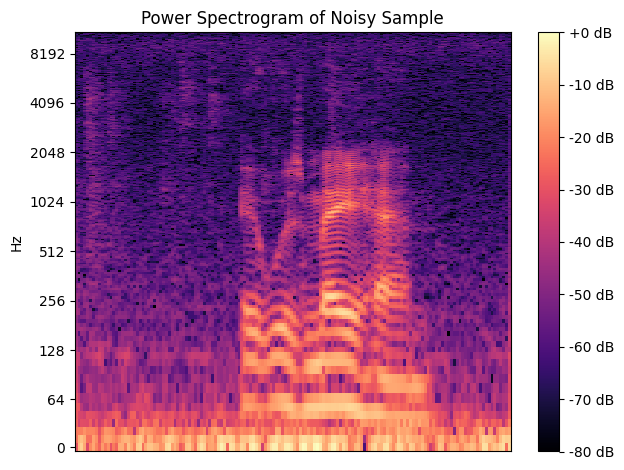

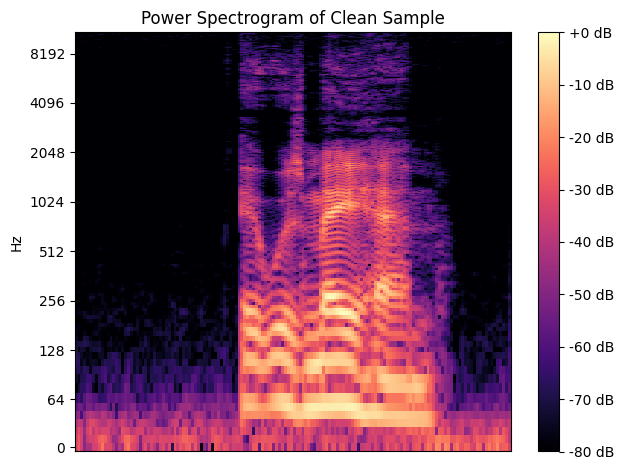

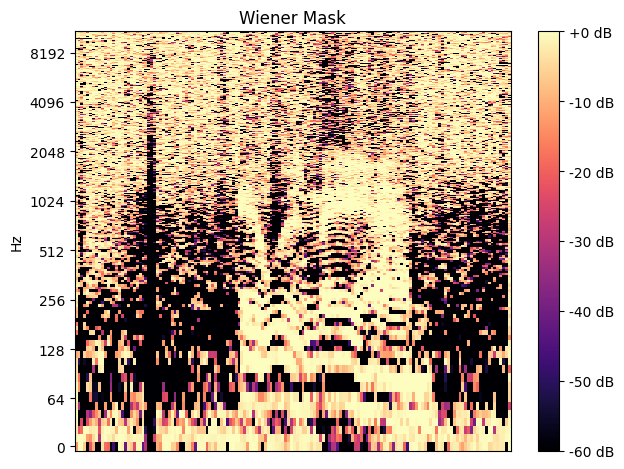

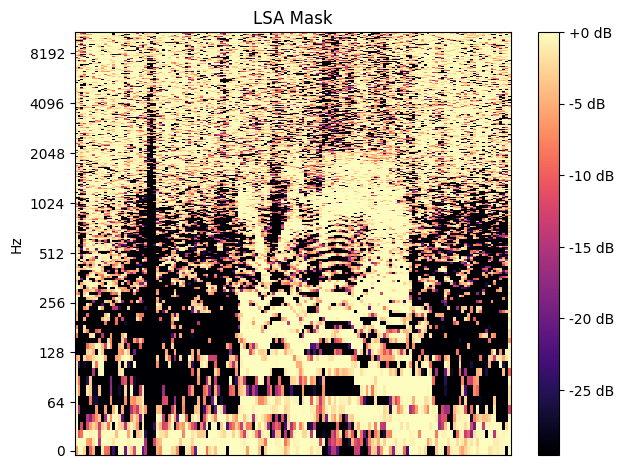

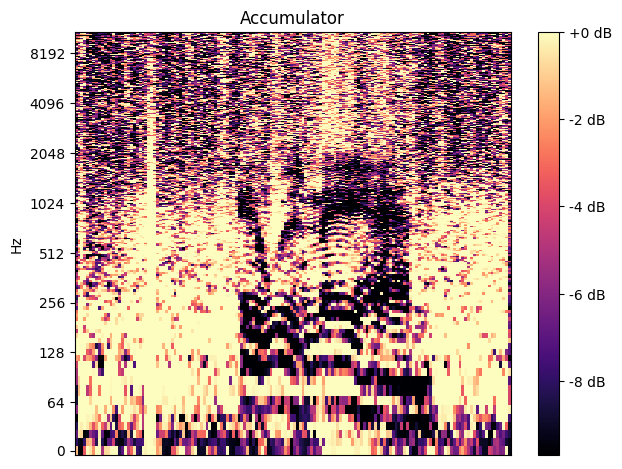

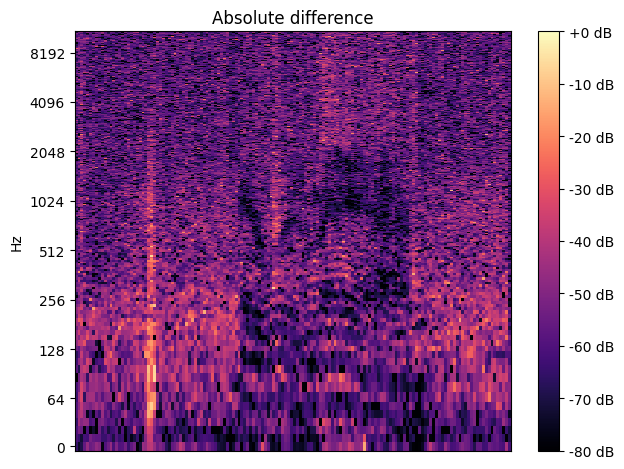

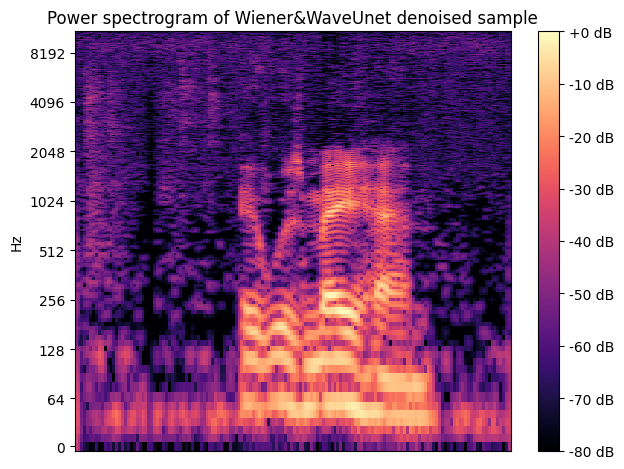

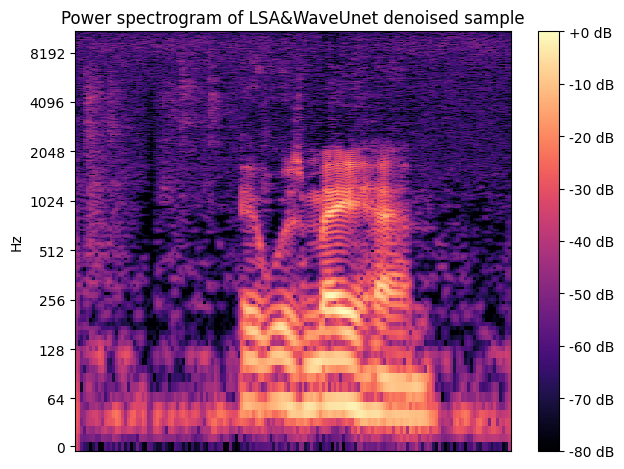

SNR of WaveUNet&Wiener denoised signal : 12.660923453800114
SNR of WaveUNet&LSA denoised signal : 15.341756175937203
PSNR of WaveUNet&Wiener denoised signal : 30.186647590075758
PSNR of WaveUNet&LSA denoised signal : 32.86748031221285
SSIM of WaveUNet&Wiener denoised signal : 0.8146424722570971
SSIM of WaveUNet&LSA denoised signal : 0.8103952655867487


In [9]:
model = Unet(nlayers=nlayers, nefilters=60).cuda() 
file = "p232_100"
model.load_state_dict(torch.load(f"/kaggle/working/Models/{file}.pth"))
model.eval()
with open(f'/kaggle/working/Accumulator classes/{file}.pkl', 'rb') as f:
    accumulator=pickle.load(f)
noisy_file=os.path.join('/kaggle/input/audio-dataset/Dataset/noisy dataset',f"{file}.wav")
clean_file=os.path.join('/kaggle/input/audio-dataset/Dataset/clean dataset',f"{file}.wav")
target,sr=load_wav_to_torch(noisy_file)
clean_target,sr=load_wav_to_torch(clean_file)
target=process_torch(target,nlayers)
clean_target=process_torch(clean_target,nlayers)
input=torch.rand_like(target)
input=(input-0.5)*2
target,input,clean_target=target.cuda(),input.cuda(),clean_target.cuda()
input=input.view(1,1,-1)
with torch.no_grad(): 
    output=model(input)
wiener_denoised_signal=librosa.istft(accumulator.filter_stft()*accumulator.atten_map,hop_length=accumulator.hop_length)/32768.0
lsa_denoised_signal=librosa.istft(accumulator.filter_stft()*accumulator.lsa_mask,hop_length=accumulator.hop_length)/32768.0
plot_stft(np.abs(torch_stft(target,nfft=accumulator.nfft,hop_length=accumulator.hop_length)),"Power Spectrogram of Noisy Sample")
plot_stft(np.abs(torch_stft(clean_target,nfft=accumulator.nfft,hop_length=accumulator.hop_length)),"Power Spectrogram of Clean Sample")
plot_stft(accumulator.atten_map,'Wiener Mask')
plot_stft(accumulator.lsa_mask,'LSA Mask')
plot_stft(accumulator.stft_diff_sum,'Accumulator')
plot_stft(accumulator.stft_minus,'Absolute difference')
plot_stft(np.abs(librosa.stft(wiener_denoised_signal,n_fft=accumulator.nfft,hop_length=accumulator.hop_length)),"Power spectrogram of Wiener&WaveUnet denoised sample")
plot_stft(np.abs(librosa.stft(lsa_denoised_signal,n_fft=accumulator.nfft,hop_length=accumulator.hop_length)),"Power spectrogram of LSA&WaveUnet denoised sample")
print(f"SNR of WaveUNet&Wiener denoised signal : {accumulator.compute_snr(clean_target.cpu().numpy(),wiener_denoised_signal)}")
print(f"SNR of WaveUNet&LSA denoised signal : {accumulator.compute_snr(clean_target.cpu().numpy(),lsa_denoised_signal)}")
print(f"PSNR of WaveUNet&Wiener denoised signal : {accumulator.compute_psnr(clean_target.cpu().numpy(),wiener_denoised_signal)}")
print(f"PSNR of WaveUNet&LSA denoised signal : {accumulator.compute_psnr(clean_target.cpu().numpy(),lsa_denoised_signal)}")
print(f"SSIM of WaveUNet&Wiener denoised signal : {accumulator.compute_ssim(clean_target.cpu().numpy(),wiener_denoised_signal)}")
print(f"SSIM of WaveUNet&LSA denoised signal : {accumulator.compute_ssim(clean_target.cpu().numpy(),lsa_denoised_signal)}")                                        

In [10]:
!zip -r /kaggle/working/my_files.zip /kaggle/working/*
!wget /kaggle/working/my_files.zip

  adding: kaggle/working/Absolute differences/ (stored 0%)
  adding: kaggle/working/Absolute differences/p232_006.png (deflated 2%)
  adding: kaggle/working/Absolute differences/p232_037.png (deflated 3%)
  adding: kaggle/working/Absolute differences/p232_014.png (deflated 2%)
  adding: kaggle/working/Absolute differences/p232_007.png (deflated 8%)
  adding: kaggle/working/Absolute differences/p232_064.png (deflated 3%)
  adding: kaggle/working/Absolute differences/p232_057.png (deflated 3%)
  adding: kaggle/working/Absolute differences/p232_036.png (deflated 3%)
  adding: kaggle/working/Absolute differences/p232_046.png (deflated 4%)
  adding: kaggle/working/Absolute differences/p232_054.png (deflated 3%)
  adding: kaggle/working/Absolute differences/p232_102.png (deflated 3%)
  adding: kaggle/working/Absolute differences/p232_101.png (deflated 3%)
  adding: kaggle/working/Absolute differences/p232_059.png (deflated 4%)
  adding: kaggle/working/Absolute differences/p232_088.png (defla